<a href="https://colab.research.google.com/github/ANeuralDip/ML/blob/master/Oxford_IIIT_Pets_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Oxford Pets/")

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
annotations  images


In [5]:
input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")])

target_paths = sorted(
    [os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

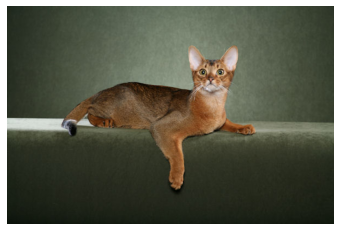

In [6]:
import matplotlib.pyplot as plt 
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[9])) 

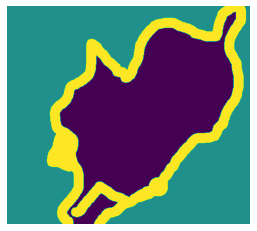

In [7]:
def display_target(target_array):
 normalized_array = (target_array.astype("uint8") - 1) * 127 
 plt.axis("off")
 plt.imshow(normalized_array[:, :, 0])
img = img_to_array(load_img(target_paths[9], color_mode="grayscale")) 
display_target(img)

In [8]:
import numpy as np 
import random 

img_size = (200, 200) 
num_imgs = len(input_img_paths) 
random.Random(1337).shuffle(input_img_paths) 
random.Random(1337).shuffle(target_paths) 


def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1 
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32") 
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8") 
for i in range(num_imgs): 
    input_imgs[i] = path_to_input_image(input_img_paths[i]) 
    targets[i] = path_to_target(target_paths[i]) 

num_val_samples = 1000 
train_input_imgs = input_imgs[:-num_val_samples] 
train_targets = targets[:-num_val_samples] 
val_input_imgs = input_imgs[-num_val_samples:] 
val_targets = targets[-num_val_samples:]

In [9]:
from tensorflow import keras 
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs) 
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
    256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
    128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
    64, 3, activation="relu", padding="same", strides=2)(x)
 
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", 
    padding="same")(x) 
 
    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [10]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
    epochs=50,
    callbacks=callbacks,
    batch_size=64,
    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 159s 1s/step - loss: 1.2619 - val_loss: 0.9699
Epoch 2/50
100/100 [==============================] - 130s 1s/step - loss: 0.9218 - val_loss: 0.8923
Epoch 3/50
100/100 [==============================] - 129s 1s/step - loss: 0.8260 - val_loss: 0.7604
Epoch 4/50
100/100 [==============================] - 129s 1s/step - loss: 0.7915 - val_loss: 0.7238
Epoch 5/50
100/100 [==============================] - 129s 1s/step - loss: 0.7267 - val_loss: 0.7273
Epoch 6/50
100/100 [==============================] - 129s 1s/step - loss: 0.6904 - val_loss: 0.7605
Epoch 7/50
100/100 [==============================] - 130s 1s/step - loss: 0.6483 - val_loss: 0.5833
Epoch 8/50
100/100 [==============================] - 129s 1s/step - loss: 0.6177 - val_loss: 0.6297
Epoch 9/50
100/100 [==============================] - 130s 1s/step - loss: 0.5949 - val_loss: 0.5380
Epoch 10/50
100/100 [==============================] - 129s 1s/step - loss: 0.5691 - val_lo

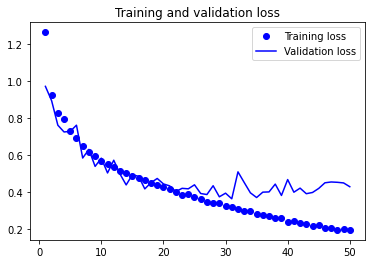

In [11]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()


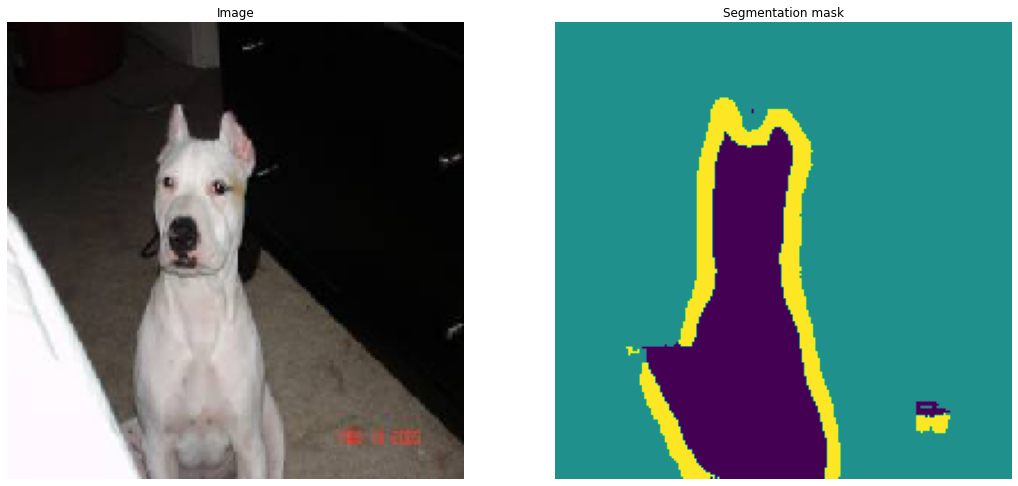

In [27]:
from tensorflow.keras.utils import array_to_img
import matplotlib.pyplot as plt

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred): 
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

fig = plt.figure(figsize=(18, 16))
fig.add_subplot(1, 2, 1)
plt.axis("off")
plt.title("Image")
plt.imshow(array_to_img(test_image))
fig.add_subplot(1, 2, 2)
plt.title("Segmentation mask")
display_mask(mask)